# Arima Models for California Counties 

In [4]:
import warnings
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, mean_squared_error
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima.model import ARIMA

In [5]:
data = pd.read_csv('finalized_county.csv')

In [6]:
california_data = data[data['state'] == 'California']
california_data['date'] = pd.to_datetime(california_data['date'], format="%Y-%m-%d")
california_data['county'].unique()

array(['Los Angeles', 'Orange', 'San Diego'], dtype=object)

# Los Angeles

In [11]:
la = california_data[california_data['county'] == 'Los Angeles'].loc[:, ['date', 'incremental_cases']]
la['incremental_cases'] = la['incremental_cases'].astype('int')
la['date'] = pd.to_datetime(la['date'], format="%Y-%m-%d")

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])

# Los Angeles is non-stationary
print("Stationary or not?:", stationary_test(la.incremental_cases))

# get this value for reversion purposes
print(la.loc[la['date'] == '2020-10-25', 'incremental_cases'])

# first-level differencing
la['incremental_cases'] = la['incremental_cases'].diff(
).fillna(la['incremental_cases']).astype('int')

# Los Angeles is still non-stationary after first-level differencing
print("Stationary after first level diff?:", stationary_test(la.incremental_cases))

# get this value for reversion purposes
print(la.loc[la['date'] == '2020-10-25', 'incremental_cases'])

# second-level differencing
la['incremental_cases'] = la['incremental_cases'].diff(
).fillna(la['incremental_cases']).astype('int')

# Los Angeles is stationary after second-level differencing
print("Stationary after second level diff?:", stationary_test(la.incremental_cases))

Stationary or not?: (1.3190762222252403, 0.9967136380720155)
229    823
Name: incremental_cases, dtype: int64
Stationary after first level diff?: (-0.934092662079519, 0.7765380334868845)
229   -1293
Name: incremental_cases, dtype: int64
Stationary after second level diff?: (-8.591013100393987, 7.286147751265899e-14)


In [12]:
la.shape

(270, 2)

In [13]:
# use 85%-15% for train-test split
train = la.iloc[:230, :]
test = la.iloc[230:, :]

<Axes: xlabel='date', ylabel='incremental_cases'>

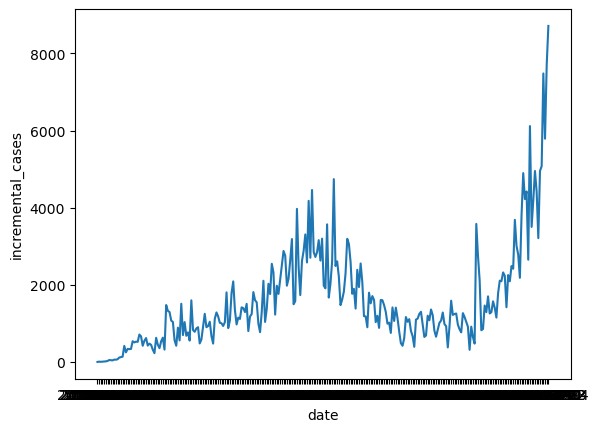

In [14]:
# use non-differenced cases for test actuals
testing = data[data['county'] == 'Los Angeles'].loc[:, ['date', 'incremental_cases']]
test = testing.iloc[230:, :]

# Plotting actual test data
sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=testing)

In [16]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')
n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

p_values = [0, 1, 2, 3, 4, 5]
d_values = [2]
q_values = [0, 1, 2, 3, 4, 5]

best_score, best_cfg = float("inf"), None

# Iterate through all combinations of p, d, q values
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            mse_scores = []

            # Cross-validation
            for train_index, val_index in tscv.split(train):
                train_data, val_data = train.iloc[train_index], train.iloc[val_index]
                
                try:
                    model = ARIMA(train_data.incremental_cases, order=order)
                    model_fit = model.fit()
                    forecast = model_fit.forecast(steps=len(val_data))
                    mse = mean_squared_error(val_data.incremental_cases, forecast)
                    mse_scores.append(mse)
                except:
                    mse_scores.append(float("inf"))
            
            # Average MSE across all CV splits for the current parameter set
            average_mse = np.mean(mse_scores)

            # Update the best configuration if the current average MSE is lower than the best score
            if average_mse < best_score:
                best_score, best_cfg = average_mse, order

print(f'Best ARIMA parameters: {best_cfg} with MSE: {best_score}')

Best ARIMA parameters: (0, 2, 5) with MSE: 1244510.5213075986


In [22]:
model = ARIMA(train.incremental_cases, order=(1, 0, 2)).fit()
pred = pd.concat([pd.Series([-1293]), model.forecast(steps=40)]).cumsum()[1:]
pred = pd.concat([pd.Series([823]), pred]).cumsum()[1:]

r2 = r2_score(test.incremental_cases, pred)
print("R-squared", r2) 

R-squared 0.15015830985368173


<Axes: xlabel='date'>

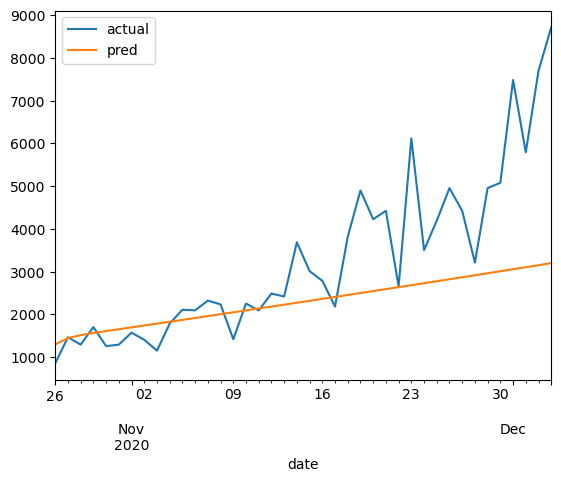

In [29]:
test['date'] = pd.to_datetime(test['date'], format="%Y-%m-%d")
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])


In [30]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')
n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

p_values = [0, 1, 2, 3, 4, 5]
d_values = [2]
q_values = [0, 1, 2, 3, 4, 5, 6, 7, 8]

best_score, best_cfg = float("inf"), None

# Iterate through all combinations of p, d, q values
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            mse_scores = []

            # Cross-validation as the inner loop
            for train_index, val_index in tscv.split(train):
                train_data, val_data = train.iloc[train_index], train.iloc[val_index]
                
                try:
                    model = ARIMA(train_data.incremental_cases, order=order)
                    model_fit = model.fit()
                    forecast = model_fit.forecast(steps=len(val_data))
                    mse = mean_squared_error(val_data.incremental_cases, forecast)
                    mse_scores.append(mse)
                except:
                    mse_scores.append(float("inf"))
            
            # Average MSE across all CV splits for the current parameter set
            average_mse = np.mean(mse_scores)

            # Update the best configuration if the current average MSE is lower than the best score
            if average_mse < best_score:
                best_score, best_cfg = average_mse, order

print(f'Best ARIMA parameters: {best_cfg} with MSE: {best_score}')

Best ARIMA parameters: (4, 2, 6) with MSE: 1223096.279473607


In [31]:
model = ARIMA(train.incremental_cases, order=(4, 2, 6)).fit()
pred = pd.concat([pd.Series([-1293]), model.forecast(steps=40)]).cumsum()[1:]
pred = pd.concat([pd.Series([823]), pred]).cumsum()[1:]

r2 = r2_score(test.incremental_cases, pred)
print("R-squared", r2) 

R-squared 0.2864947813179809


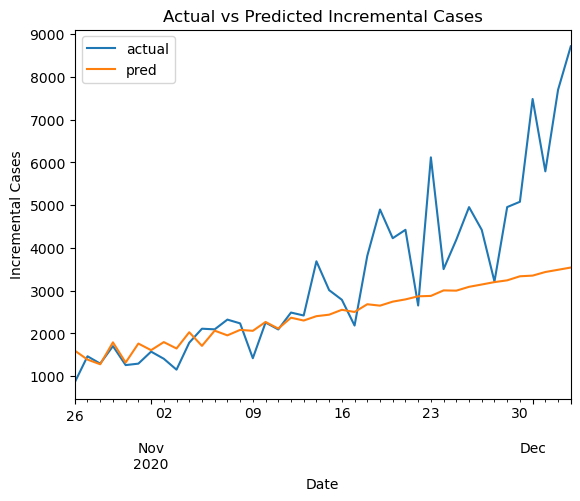

In [33]:
# Plotting
test['date'] = pd.to_datetime(test['date'], format="%Y-%m-%d")

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
ax = prediction.plot(x = 'date', y = ['actual', 'pred'])

ax.set_xlabel('Date')
ax.set_ylabel('Incremental Cases')

ax.set_title('Actual vs Predicted Incremental Cases')

plt.show()

In [34]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      incremental_cases   No. Observations:                  230
Model:                 ARIMA(4, 2, 6)   Log Likelihood               -1804.382
Date:                Sun, 25 Feb 2024   AIC                           3630.764
Time:                        20:28:55   BIC                           3668.487
Sample:                             0   HQIC                          3645.984
                                - 230                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.5057      0.126    -19.892      0.000      -2.753      -2.259
ar.L2         -2.9002      0.263    -11.014      0.000      -3.416      -2.384
ar.L3         -1.7977      0.261     -6.889      0.000      -2.309      -1.286
ar.L4         -0.4375      0.123     -3.559      0.000      -0.678      -0.197
ma.L1         -0.7074      0.276     -2.564      0.010      -1.248      -0.167
ma.L2         -1.4391      0.311     -4.624      0.000      -2.049      -0.829
ma.L3         -0.0397      0.284     -0.140      0.889      -0.596       0.517
ma.L4          1.3889      0.342      4.062      0.000       0.719       2.059
ma.L5          0.7472      0.291      2.572      0.010       0.178       1.317
ma.L6         -0.9487      0.142     -6.697      0.000      -1.226      -0.671
sigma2      6.859e+05   2.03e-06   3.38e+11      0.000    6.86e+05    6.86e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.45   Jarque-Bera (JB):               280.06
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               3.21   Skew:                             0.98
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.1e+26. Standard errors may be unstable.
"""

# Orange

In [23]:
orange = california_data[california_data['county'] == 'Orange'].loc[:, ['date', 'incremental_cases']]
orange['incremental_cases'] = orange['incremental_cases'].astype('int')
orange['date'] = pd.to_datetime(orange['date'], format="%Y-%m-%d")

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])

# Orange is non-stationary
print("Stationary or not?:", stationary_test(orange.incremental_cases))

# get this value for reversion purposes
print(orange.loc[orange['date'] == '2020-10-25', 'incremental_cases'])

# first-level differencing
orange['incremental_cases'] = orange['incremental_cases'].diff(
).fillna(orange['incremental_cases']).astype('int')

# Los Angeles is still non-stationary after first-level differencing
print("Stationary after first level diff?:", stationary_test(orange.incremental_cases))

Stationary or not?: (-0.1897980045327783, 0.9397267929055788)
499    247
Name: incremental_cases, dtype: int64
Stationary after first level diff?: (-10.476734705085976, 1.243438566263163e-18)


In [24]:
orange.shape

(270, 2)

In [25]:
# use 85%-15% for train-test split
train = orange.iloc[:230, :]
test = orange.iloc[230:, :]

<Axes: xlabel='date', ylabel='incremental_cases'>

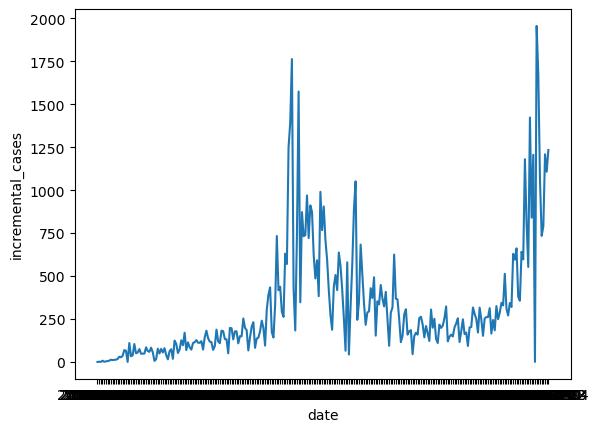

In [26]:
# use non-differenced cases for test actuals
testing = data[data['county'] == 'Orange'].loc[:, ['date', 'incremental_cases']]
test = testing.iloc[230:, :]

# Plotting actual test data
sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=testing)

In [27]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')
n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

p_values = [0, 1, 2, 3, 4, 5]
d_values = [1]
q_values = [0, 1, 2, 3, 4, 5]

best_score, best_cfg = float("inf"), None

# Iterate through all combinations of p, d, q values
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            mse_scores = []

            # Cross-validation
            for train_index, val_index in tscv.split(train):
                train_data, val_data = train.iloc[train_index], train.iloc[val_index]
                
                try:
                    model = ARIMA(train_data.incremental_cases, order=order)
                    model_fit = model.fit()
                    forecast = model_fit.forecast(steps=len(val_data))
                    mse = mean_squared_error(val_data.incremental_cases, forecast)
                    mse_scores.append(mse)
                except:
                    mse_scores.append(float("inf"))
            
            # Average MSE across all CV splits for the current parameter set
            average_mse = np.mean(mse_scores)

            # Update the best configuration if the current average MSE is lower than the best score
            if average_mse < best_score:
                best_score, best_cfg = average_mse, order

print(f'Best ARIMA parameters: {best_cfg} with MSE: {best_score}')

Best ARIMA parameters: (3, 1, 3) with MSE: 55146.38663849973


In [28]:
model = ARIMA(train.incremental_cases, order=(3, 1, 3)).fit()
pred = pd.concat([pd.Series([247]), model.forecast(steps=40)]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print("R-squared", r2) 

R-squared -0.568328951459945


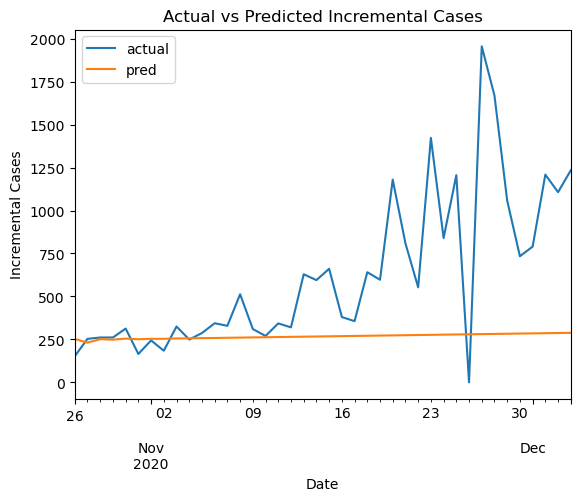

In [29]:
# Plotting

test['date'] = pd.to_datetime(test['date'], format="%Y-%m-%d")

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
ax = prediction.plot(x = 'date', y = ['actual', 'pred'])

ax.set_xlabel('Date')
ax.set_ylabel('Incremental Cases')

ax.set_title('Actual vs Predicted Incremental Cases')

plt.show()

In [30]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      incremental_cases   No. Observations:                  230
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1510.398
Date:                Fri, 08 Mar 2024   AIC                           3034.795
Time:                        21:32:25   BIC                           3058.831
Sample:                             0   HQIC                          3044.492
                                - 230                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1748      0.149     -1.172      0.241      -0.467       0.117
ar.L2         -0.0273      0.079     -0.344      0.731      -0.183       0.128
ar.L3         -0.2150      0.037     -5.741      0.000      -0.288      -0.142
ma.L1         -1.3658      0.190     -7.205      0.000      -1.737      -0.994
ma.L2          0.0906      0.311      0.291      0.771      -0.519       0.700
ma.L3          0.2752      0.139      1.984      0.047       0.003       0.547
sigma2      3.028e+04   9.07e-06   3.34e+09      0.000    3.03e+04    3.03e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               553.49
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              13.94   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.86e+25. Standard errors may be unstable.
"""

# San Diego

In [62]:
sandiego = california_data[california_data['county'] == 'San Diego'].loc[:, ['date', 'incremental_cases']]
sandiego['incremental_cases'] = sandiego['incremental_cases'].astype('int')
sandiego['date'] = pd.to_datetime(sandiego['date'], format="%Y-%m-%d")

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])

# Los Angeles is non-stationary
print("Stationary or not?:", stationary_test(sandiego.incremental_cases))

# get this value for reversion purposes
print(sandiego.loc[sandiego['date'] == '2020-10-25', 'incremental_cases'])

# first-level differencing
sandiego['incremental_cases'] = sandiego['incremental_cases'].diff(
).fillna(sandiego['incremental_cases']).astype('int')

# Los Angeles is still non-stationary after first-level differencing
print("Stationary after first level diff?:", stationary_test(sandiego.incremental_cases))

# get this value for reversion purposes
print(sandiego.loc[sandiego['date'] == '2020-10-25', 'incremental_cases'])

# second-level differencing
sandiego['incremental_cases'] = sandiego['incremental_cases'].diff(
).fillna(sandiego['incremental_cases']).astype('int')

# Los Angeles is stationary after second-level differencing
print("Stationary after second level diff?:", stationary_test(sandiego.incremental_cases))

Stationary or not?: (0.6357611259888307, 0.9884647007943559)
769    269
Name: incremental_cases, dtype: int64
Stationary after first level diff?: (-1.5064452750852018, 0.5303205781258837)
769   -117
Name: incremental_cases, dtype: int64
Stationary after second level diff?: (-7.545305190841254, 3.2955778088676166e-11)


In [63]:
sandiego.shape

(270, 2)

In [64]:
# use 85%-15% for train-test split
train = sandiego.iloc[:230, :]
test = sandiego.iloc[230:, :]

<Axes: xlabel='date', ylabel='incremental_cases'>

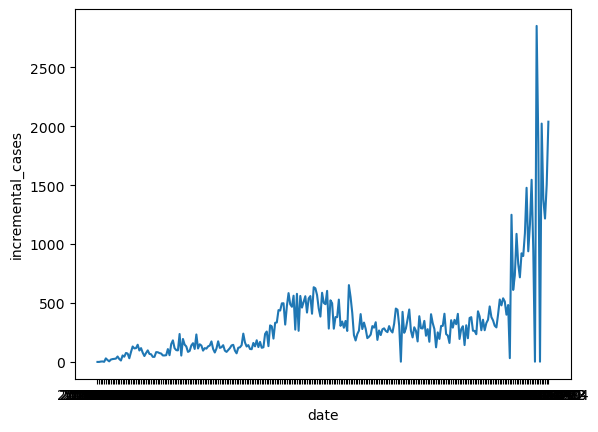

In [65]:
# use non-differenced cases for test actuals
testing = data[data['county'] == 'San Diego'].loc[:, ['date', 'incremental_cases']]
test = testing.iloc[230:, :]

# Plotting actual test data
sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=testing)

In [66]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')
n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

p_values = [0, 1, 2, 3, 4, 5, 6]
d_values = [2]
q_values = [0, 1, 2, 3, 4, 5, 6]

best_score, best_cfg = float("inf"), None

# Iterate through all combinations of p, d, q values
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            mse_scores = []

            # Cross-validation
            for train_index, val_index in tscv.split(train):
                train_data, val_data = train.iloc[train_index], train.iloc[val_index]
                
                try:
                    model = ARIMA(train_data.incremental_cases, order=order)
                    model_fit = model.fit()
                    forecast = model_fit.forecast(steps=len(val_data))
                    mse = mean_squared_error(val_data.incremental_cases, forecast)
                    mse_scores.append(mse)
                except:
                    mse_scores.append(float("inf"))
            
            # Average MSE across all CV splits for the current parameter set
            average_mse = np.mean(mse_scores)

            # Update the best configuration if the current average MSE is lower than the best score
            if average_mse < best_score:
                best_score, best_cfg = average_mse, order

print(f'Best ARIMA parameters: {best_cfg} with MSE: {best_score}')

Best ARIMA parameters: (2, 2, 2) with MSE: 41263.37213241713


In [67]:
model = ARIMA(train.incremental_cases, order=(2, 2, 2)).fit()
pred = pd.concat([pd.Series([269]), model.forecast(steps=40)]).cumsum()[1:]
pred = pd.concat([pd.Series([-117]), pred]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print("R-squared", r2) 

R-squared -114.91074035914201


<Axes: xlabel='date'>

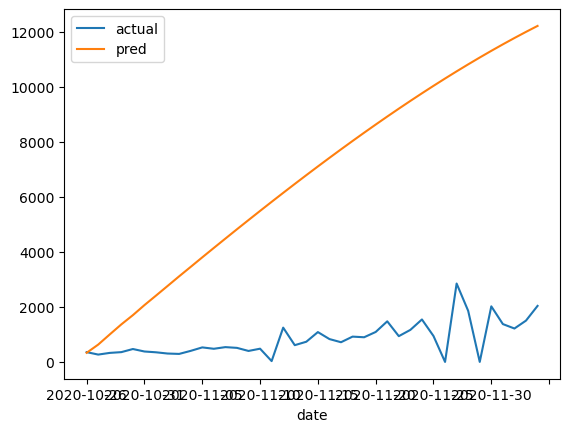

In [68]:
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

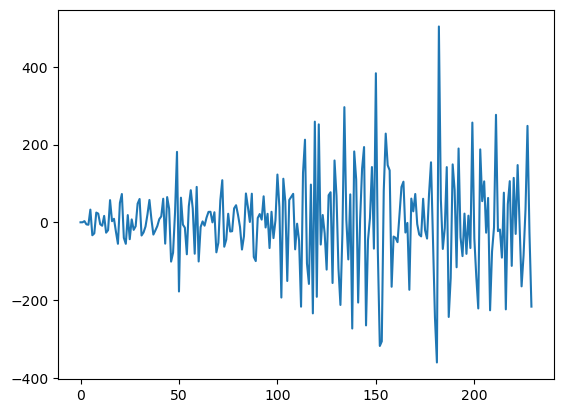

In [69]:
plt.plot(model.resid)

In [70]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      incremental_cases   No. Observations:                  230
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -1417.982
Date:                Fri, 08 Mar 2024   AIC                           2845.963
Time:                        21:38:33   BIC                           2863.110
Sample:                             0   HQIC                          2852.882
                                - 230                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0135      0.052    -19.674      0.000      -1.114      -0.913
ar.L2         -0.4501      0.052     -8.653      0.000      -0.552      -0.348
ma.L1         -1.9960      2.500     -0.798      0.425      -6.896       2.904
ma.L2          0.9995      2.503      0.399      0.690      -3.906       5.905
sigma2      1.359e+04   3.41e+04      0.398      0.690   -5.33e+04    8.05e+04
===================================================================================
Ljung-Box (L1) (Q):                   5.25   Jarque-Bera (JB):                41.19
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               7.32   Skew:                             0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""